<a href="https://colab.research.google.com/github/haarsh09/RESNET_PAPER_IMPLEMENTATION/blob/main/RESNET_implementation_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTALLATION AND MOUNTING DRIVE**

In [ ]:
!pip install -q torch torchvision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORT**

In [1]:
import os
import math
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


**DATA LOADERS**

In [2]:
# 3) Data pipeline (CIFAR-10, paper augmentation: pad 4, random crop, flip)
def get_cifar10_loaders(batch_size=128, num_workers=4):
    # CIFAR mean/std (standard)
    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)

    train_transform = T.Compose([
        T.Pad(4),                       # according to the paper I have padded 4 pixels on each side.
        T.RandomCrop(32),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(cifar_mean, cifar_std)
    ])
    test_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(cifar_mean, cifar_std)
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader


BUILDING THE ARCHITECTURE WITH SAME PARAMETERS AS DESCRIBED IN THE PAPER

In [3]:
# 4) Model building blocks
# I have implemented => BasicBlock(has residual connections) and PlainBlock (no residual).
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, in_planes if planes==in_planes and stride==1 else planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        # if dimensions change (stride>1 or channels change), I use projection
        self.need_proj = (stride != 1) or (in_planes != planes)
        if self.need_proj:
            # projection shortcut (1x1 conv) to match dimensions; paper used identity with padding for CIFAR experiments,
            # but projection is fine and used for ImageNet when dims increase; either is acceptable. I have used proj here.
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        sc  = self.shortcut(x)
        out = out + sc
        out = F.relu(out, inplace=True)
        return out

class PlainBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.make_proj = (stride != 1) or (in_planes != planes)
        if self.make_proj:
            # when size or channels change in plain net, downsample via conv
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        else:
            self.down = None

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        if self.down is not None:
            out = out + self.down(x)  # note: we still combine for dimension matching but this is NOT a residual
            # However to make plain baseline match capacity, the original plain net doesn't sum; instead it just continues stacked.
        out = F.relu(out, inplace=True)
        return out


In [4]:
# 5) CIFAR constructors for both architectures
class CIFARNet(nn.Module):
    def __init__(self, block, num_blocks_per_stage, num_classes=10, base_channels=16, plain=False):

        # block: BasicBlock or PlainBlock class
        # num_blocks_per_stage: n (number of block pairs per stage) -> total layers = 6n+2 - according to paper
        # plain: if True, plain network (no residual addition)

        super().__init__()
        self.in_planes = base_channels
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(base_channels)
        # stages: channels [16,32,64] with strides [1,2,2] => paper schedule
        self.layers = nn.ModuleList()
        channels = [base_channels, base_channels*2, base_channels*4]  # 16,32,64
        strides = [1, 2, 2]
        for ch, s in zip(channels, strides):
            blocks = []
            # The paper uses 2n conv layers per stage, but build blocks accordingly:
            num_blocks = num_blocks_per_stage
            for i in range(num_blocks):
                stride = s if i==0 else 1
                blocks.append(block(self.in_planes, ch, stride=stride))
                self.in_planes = ch
            self.layers.append(nn.Sequential(*blocks))

        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.in_planes, num_classes)

        # weight init (Kaiming) as used in the paper.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        for stage in self.layers:
            out = stage(out)
        out = self.global_avg(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def resnet_cifar(depth=56, plain=False):
    # depth = 6n + 2 -> n = (depth-2)/6
    assert (depth-2) % 6 == 0, "depth must be 6n+2"
    n = (depth - 2) // 6
    block = BasicBlock if not plain else PlainBlock
    return CIFARNet(block, num_blocks_per_stage=n, plain=plain)


In [5]:
# 6) Training & evaluation loops
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0)
            res.append((correct_k * 100.0 / batch_size).item())
        return res[0]

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc  = 0.0
    n = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        bs = x.size(0)
        running_loss += loss.item()*bs
        running_acc  += (out.argmax(dim=1)==y).sum().item()
        n += bs
    return running_loss / n, 100.0 * running_acc / n

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc  = 0.0
    n = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            bs = x.size(0)
            running_loss += loss.item()*bs
            running_acc  += (out.argmax(dim=1)==y).sum().item()
            n += bs
    return running_loss / n, 100.0 * running_acc / n


In [6]:
# 7) We can run the full experiment by running this function
def run_experiment(save_dir, model_type='resnet', depth=56, batch_size=128, num_epochs=164, lr=0.1):
    os.makedirs(save_dir, exist_ok=True)
    train_loader, test_loader = get_cifar10_loaders(batch_size=batch_size)
    # model
    plain = (model_type == 'plain')
    model = resnet_cifar(depth=depth, plain=plain).to(DEVICE)
    # optimizer + scheduler (lr drop at epochs 82 and 123 approximating paper schedule)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    csv_path = os.path.join(save_dir, f"{model_type}_depth{depth}_log.csv")
    with open(csv_path, "w", newline="") as csvfile:
        w = csv.writer(csvfile)
        w.writerow(["epoch","train_loss","train_acc","test_loss","test_acc","lr"])

    best_test_acc = 0.0
    for epoch in range(1, num_epochs+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
        test_loss, test_acc = eval_model(model, test_loader, criterion, DEVICE)
        lr_current = optimizer.param_groups[0]['lr']
        scheduler.step()

        print(f"[{model_type}] Epoch {epoch}/{num_epochs}  lr={lr_current:.3e}  train_acc={train_acc:.2f}%  test_acc={test_acc:.2f}%")

        with open(csv_path, "a", newline="") as csvfile:
            w = csv.writer(csvfile)
            w.writerow([epoch, train_loss, train_acc, test_loss, test_acc, lr_current])


        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), os.path.join(save_dir, f"{model_type}_best.pth"))

    print("Best test acc:", best_test_acc)
    return csv_path, os.path.join(save_dir, f"{model_type}_best.pth")


In [7]:
# 8) Plotting utility to compare two CSV logs
def plot_logs(csv_paths, labels=None):
    plt.figure(figsize=(12,5))
    # two subplots: accuracy and loss
    for p,label in zip(csv_paths, labels):
        data = np.genfromtxt(p, delimiter=",", names=True)
        epochs = data['epoch']
        plt.subplot(1,2,1)
        plt.plot(epochs, data['train_acc'], linestyle='--', label=f"{label} train")
        plt.plot(epochs, data['test_acc'],  linestyle='-',  label=f"{label} test")
        plt.subplot(1,2,2)
        plt.plot(epochs, data['train_loss'], linestyle='--', label=f"{label} train")
        plt.plot(epochs, data['test_loss'],  linestyle='-',  label=f"{label} test")
    plt.subplot(1,2,1)
    plt.title("Accuracy (%)")
    plt.xlabel("Epoch")
    plt.legend()
    plt.subplot(1,2,2)
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()


100%|██████████| 170M/170M [00:08<00:00, 19.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[resnet] Epoch 1/100  lr=1.000e-01  train_acc=27.40%  test_acc=38.06%
[resnet] Epoch 2/100  lr=1.000e-01  train_acc=44.10%  test_acc=43.97%
[resnet] Epoch 3/100  lr=1.000e-01  train_acc=56.31%  test_acc=57.48%
[resnet] Epoch 4/100  lr=1.000e-01  train_acc=65.56%  test_acc=64.39%
[resnet] Epoch 5/100  lr=1.000e-01  train_acc=72.37%  test_acc=72.65%
[resnet] Epoch 6/100  lr=1.000e-01  train_acc=75.49%  test_acc=68.73%
[resnet] Epoch 7/100  lr=1.000e-01  train_acc=78.11%  test_acc=75.80%
[resnet] Epoch 8/100  lr=1.000e-01  train_acc=79.85%  test_acc=76.73%
[resnet] Epoch 9/100  lr=1.000e-01  train_acc=81.35%  test_acc=77.92%
[resnet] Epoch 10/100  lr=1.000e-01  train_acc=82.51%  test_acc=81.03%
[resnet] Epoch 11/100  lr=1.000e-01  train_acc=83.63%  test_acc=80.96%
[resnet] Epoch 12/100  lr=1.000e-01  train_acc=84.16%  test_acc=83.33%
[resnet] Epoch 13/100  lr=1.000e-01  train_acc=84.95%  test_acc=81.41%
[resnet] Epoch 14/100  lr=1.000e-01  train_acc=85.74%  test_acc=83.16%
[resnet] Epoch 

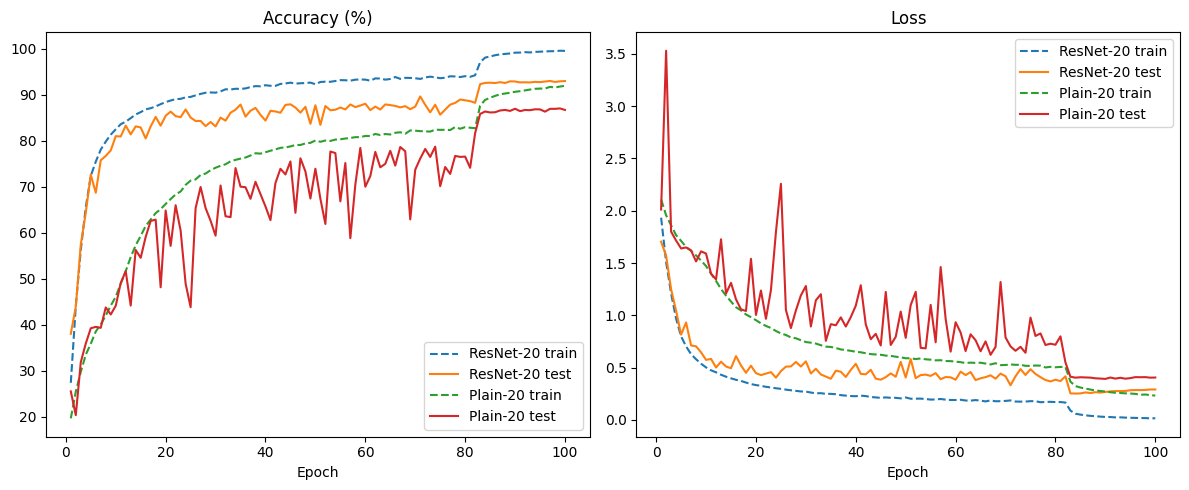

In [ ]:
from datetime import datetime

# pick a save directory (inside Colab runtime)
SAVE_DIR = "./runs/resnet_vs_plain_" + datetime.now().strftime("%Y%m%d_%H%M%S")

# quick experiment: 40 epochs (fast, just to see if code works)
csv_res, _ = run_experiment(SAVE_DIR + "/resnet", model_type='resnet', depth=56, batch_size=128, num_epochs=100, lr=0.1)
csv_plain, _ = run_experiment(SAVE_DIR + "/plain",  model_type='plain',  depth=56, batch_size=128, num_epochs=100, lr=0.1)

plot_logs([csv_res, csv_plain], labels=["ResNet-20","Plain-20"])


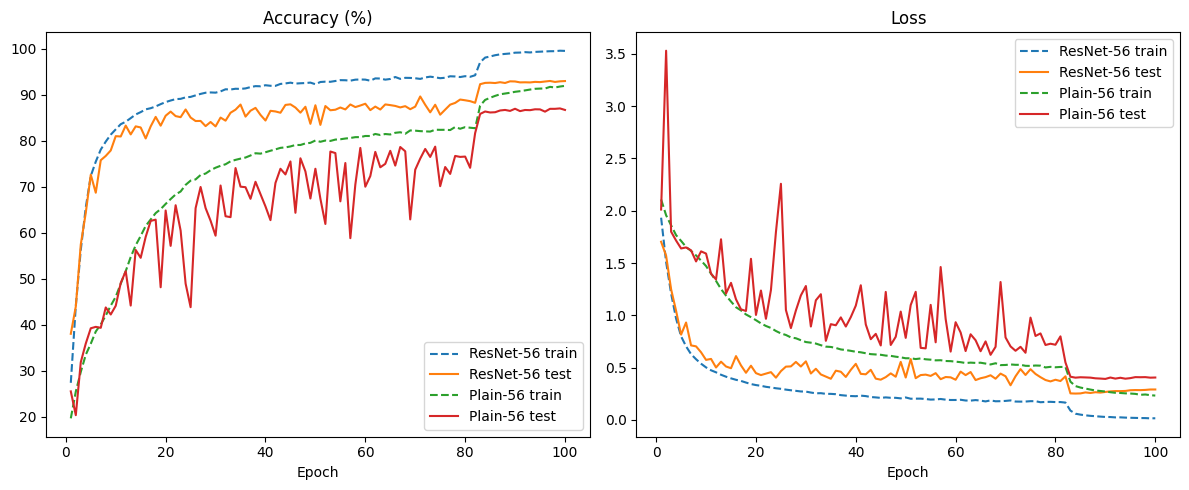

In [ ]:
plot_logs([csv_res, csv_plain], labels=["ResNet-56","Plain-56"])


##THE EXTENSION TO THE ARCHITECTURE

## MY EXTENSION TO THIS ARCHITECTURE IS TO ADD A SQUEEZE AND EXCITATION ATTENTION MODULE



In [8]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean((2,3))                  # Global Average Pooling
        y = F.relu(self.fc1(y), inplace=True)
        y = torch.sigmoid(self.fc2(y))
        y = y.view(b, c, 1, 1)
        return x * y


In [9]:
class SEBasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        self.need_proj = (stride != 1) or (in_planes != planes)
        if self.need_proj:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = nn.Identity()

        self.se = SEBlock(planes, reduction)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = self.se(out)                  # << squeeze & excitation
        sc  = self.shortcut(x)
        out = out + sc
        return F.relu(out, inplace=True)


In [10]:
def se_resnet_cifar(depth=56, num_classes=10):
    """
    CIFAR-style ResNet with SE blocks.
    depth must be 6n+2 (e.g., 20, 32, 44, 56).
    """
    assert (depth - 2) % 6 == 0, "depth must be 6n+2"
    n = (depth - 2) // 6

    in_planes = 16
    base_channels = [16, 32, 64]
    strides = [1, 2, 2]

    layers = []
    for ch, s in zip(base_channels, strides):
        stage_blocks = []
        for i in range(n):
            stride = s if i == 0 else 1
            stage_blocks.append(SEBasicBlock(in_planes, ch, stride))
            in_planes = ch
        layers.append(nn.Sequential(*stage_blocks))

    model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        *layers,
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(in_planes, num_classes)
    )

    return model.to(DEVICE)


In [11]:
def run_experiment(save_dir, model_type='resnet', depth=56, batch_size=128, num_epochs=164, lr=0.1):
    os.makedirs(save_dir, exist_ok=True)
    train_loader, test_loader = get_cifar10_loaders(batch_size=batch_size)

    # choose model
    if model_type == "plain":
        model = resnet_cifar(depth=depth, plain=True).to(DEVICE)
    elif model_type == "resnet":
        model = resnet_cifar(depth=depth, plain=False).to(DEVICE)
    elif model_type == "se_resnet":
        model = se_resnet_cifar(depth=depth).to(DEVICE)
    else:
        raise ValueError(f"Unknown model_type {model_type}")

    # optimizer + scheduler (same as paper schedule)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    csv_path = os.path.join(save_dir, f"{model_type}_depth{depth}_log.csv")
    with open(csv_path, "w", newline="") as csvfile:
        w = csv.writer(csvfile)
        w.writerow(["epoch","train_loss","train_acc","test_loss","test_acc","lr"])

    best_test_acc = 0.0
    for epoch in range(1, num_epochs+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
        test_loss, test_acc = eval_model(model, test_loader, criterion, DEVICE)
        lr_current = optimizer.param_groups[0]['lr']
        scheduler.step()

        print(f"[{model_type}] Epoch {epoch}/{num_epochs}  lr={lr_current:.3e}  train_acc={train_acc:.2f}%  test_acc={test_acc:.2f}%")

        with open(csv_path, "a", newline="") as csvfile:
            w = csv.writer(csvfile)
            w.writerow([epoch, train_loss, train_acc, test_loss, test_acc, lr_current])

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), os.path.join(save_dir, f"{model_type}_best.pth"))

    print("Best test acc:", best_test_acc)
    return csv_path, os.path.join(save_dir, f"{model_type}_best.pth")


In [ ]:
SAVE_DIR = "./runs/se_resnet56"
csv_se, best_model_path = run_experiment(SAVE_DIR, model_type="se_resnet", depth=56, num_epochs=100)


100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[se_resnet] Epoch 1/100  lr=1.000e-01  train_acc=33.63%  test_acc=41.93%
[se_resnet] Epoch 2/100  lr=1.000e-01  train_acc=54.23%  test_acc=58.51%
[se_resnet] Epoch 3/100  lr=1.000e-01  train_acc=64.78%  test_acc=62.44%
[se_resnet] Epoch 4/100  lr=1.000e-01  train_acc=71.21%  test_acc=68.69%
[se_resnet] Epoch 5/100  lr=1.000e-01  train_acc=75.71%  test_acc=75.45%
[se_resnet] Epoch 6/100  lr=1.000e-01  train_acc=78.85%  test_acc=72.67%
[se_resnet] Epoch 7/100  lr=1.000e-01  train_acc=80.47%  test_acc=79.90%
[se_resnet] Epoch 8/100  lr=1.000e-01  train_acc=82.07%  test_acc=78.39%
[se_resnet] Epoch 9/100  lr=1.000e-01  train_acc=83.64%  test_acc=79.97%
[se_resnet] Epoch 10/100  lr=1.000e-01  train_acc=84.43%  test_acc=82.01%
[se_resnet] Epoch 11/100  lr=1.000e-01  train_acc=85.38%  test_acc=83.76%
[se_resnet] Epoch 12/100  lr=1.000e-01  train_acc=85.98%  test_acc=79.32%
[se_resnet] Epoch 13/100  lr=1.000e-01  train_acc=86.67%  test_acc=83.78%
[se_resnet] Epoch 14/100  lr=1.000e-01  train_a

In [12]:
!pip install ptflops


In [13]:
from ptflops import get_model_complexity_info

def model_profile(model, input_res=(3,32,32)):
    macs, params = get_model_complexity_info(model, input_res, as_strings=False, print_per_layer_stat=False)
    flops = 2 * macs
    num_params = params
    return num_params, flops


In [14]:
se_resnet56 = se_resnet_cifar(depth=56).to(DEVICE)
params_se, flops_se = model_profile(se_resnet56)
print(f"SE-ResNet-56 → Params: {params_se/1e6:.2f}M | FLOPs: {flops_se/1e6:.2f}M")

SE-ResNet-56 → Params: 0.86M | FLOPs: 254.80M


In [15]:
resnet56 = resnet_cifar(depth=56, plain=False).to(DEVICE)
params_res, flops_res = model_profile(resnet56)
print(f"ResNet-56 → Params: {params_res/1e6:.2f}M | FLOPs: {flops_res/1e6:.2f}M")

ResNet-56 → Params: 0.86M | FLOPs: 254.76M


## RUNNING FULL TRAINING SCHEDULE FOR CONCRETE EVIDENCE THAT SE_RESNET WOULD INCREASE THE ACCURACY GAP IF TRAINED FOR 164 EPOCHS.

In [ ]:
SAVE_DIR = "./runs/se_resnet56"
csv_se, best_model_path = run_experiment(SAVE_DIR, model_type="se_resnet", depth=56, num_epochs=164)


100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[se_resnet] Epoch 1/164  lr=1.000e-01  train_acc=34.77%  test_acc=46.73%
[se_resnet] Epoch 2/164  lr=1.000e-01  train_acc=56.14%  test_acc=55.80%
[se_resnet] Epoch 3/164  lr=1.000e-01  train_acc=66.87%  test_acc=69.83%
[se_resnet] Epoch 4/164  lr=1.000e-01  train_acc=72.73%  test_acc=72.91%
[se_resnet] Epoch 5/164  lr=1.000e-01  train_acc=76.78%  test_acc=74.22%
[se_resnet] Epoch 6/164  lr=1.000e-01  train_acc=79.34%  test_acc=80.09%
[se_resnet] Epoch 7/164  lr=1.000e-01  train_acc=81.40%  test_acc=77.54%
[se_resnet] Epoch 8/164  lr=1.000e-01  train_acc=82.89%  test_acc=81.10%
[se_resnet] Epoch 9/164  lr=1.000e-01  train_acc=83.78%  test_acc=81.03%
[se_resnet] Epoch 10/164  lr=1.000e-01  train_acc=85.03%  test_acc=81.75%
[se_resnet] Epoch 11/164  lr=1.000e-01  train_acc=85.42%  test_acc=84.46%
[se_resnet] Epoch 12/164  lr=1.000e-01  train_acc=85.87%  test_acc=85.39%
[se_resnet] Epoch 13/164  lr=1.000e-01  train_acc=86.81%  test_acc=82.57%
[se_resnet] Epoch 14/164  lr=1.000e-01  train_a

## TO RUN FOR LONGER SCHEDULES I WOULD NEED A COLAB SUBSCRIPTION. BUT AS WE CAN SEE, THERE IS CONSISTENCY IN THE IMPROVEMENT OF ACCURACY WHEN SIMPLE RESNET BLOCK IS UPGRADED TO USE SQUEEZE AND EXCITATION ATTENTION, WHICH DOESNOT INCREASE THE COMPUTATIONAL OVERHEAD BUT GIVES BETTER ACCURACY.

## TO TRY THIS HYPOTHESIS AND ACTUALLY VERIFY IT WE CAN RUN THIS EXPERIMENT ON A MUCH RICHER DATASET LIKE CIFAR 100 WHICH HAS 100 CLASSES INSTEAD OF JUST 10.
## THE REASON FOR THIS IS THAT CIFAR-100 IS A BIT HARDER DATASET TO ADAPT TO WHERE THE ARCHITECTURAL IMPROVEMENT WILL SHINE.

In [16]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

def get_loaders_cifar(dataset="cifar10", batch_size=128, num_workers=2):
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2470, 0.2435, 0.2616)

    train_transform = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    if dataset.lower() == "cifar10":
        trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
        testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
        num_classes = 10
    elif dataset.lower() == "cifar100":
        trainset = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=train_transform)
        testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=test_transform)
        num_classes = 100
    else:
        raise ValueError("dataset must be 'cifar10' or 'cifar100'")

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader  = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader, num_classes


In [17]:
def run_experiment(save_dir, model_type="resnet", depth=56, batch_size=128, num_epochs=164,
                   lr=0.1, dataset="cifar10"):
    os.makedirs(save_dir, exist_ok=True)
    train_loader, test_loader, num_classes = get_loaders_cifar(dataset, batch_size=batch_size)

    # build model
    if model_type == "plain":
        model = resnet_cifar(depth=depth, plain=True, num_classes=num_classes).to(DEVICE)
    elif model_type == "resnet":
        model = resnet_cifar(depth=depth, plain=False, num_classes=num_classes).to(DEVICE)
    elif model_type == "se_resnet":
        model = se_resnet_cifar(depth=depth, num_classes=num_classes).to(DEVICE)
    else:
        raise ValueError("Unknown model_type")

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    csv_path = os.path.join(save_dir, f"{dataset}_{model_type}_depth{depth}_log.csv")
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["epoch","train_loss","train_acc","test_loss","test_acc","lr"])

    best_test_acc = 0.0
    for epoch in range(1, num_epochs+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
        test_loss, test_acc = eval_model(model, test_loader, criterion, DEVICE)
        lr_current = optimizer.param_groups[0]['lr']
        scheduler.step()

        print(f"[{dataset}-{model_type}] Epoch {epoch}/{num_epochs}  lr={lr_current:.3e}  "
              f"train_acc={train_acc:.2f}%  test_acc={test_acc:.2f}%")

        with open(csv_path, "a", newline="") as f:
            w = csv.writer(f)
            w.writerow([epoch, train_loss, train_acc, test_loss, test_acc, lr_current])

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), os.path.join(save_dir, f"{dataset}_{model_type}_best.pth"))

    print("Best test acc:", best_test_acc)
    return csv_path, os.path.join(save_dir, f"{dataset}_{model_type}_best.pth")


In [18]:
# Replace your old resnet_cifar wrapper with this one
def resnet_cifar(depth=20, plain=False, num_classes=10, base_channels=16):
    """
    CIFAR-style ResNet factory that forwards num_classes to CIFARNet.
    depth must be 6n+2 (e.g., 20, 32, 44, 56, 110).
    """
    assert (depth - 2) % 6 == 0, "depth must be 6n+2"
    n = (depth - 2) // 6
    block = BasicBlock if not plain else PlainBlock
    # CIFARNet signature: CIFARNet(block, num_blocks_per_stage, num_classes=10, base_channels=16, plain=False)
    return CIFARNet(block, num_blocks_per_stage=n, num_classes=num_classes, base_channels=base_channels, plain=plain)


In [ ]:
# ResNet-56 on CIFAR-100
csv_resnet100, _ = run_experiment("./runs/cifar100_resnet56", model_type="resnet", depth=56, num_epochs=164, dataset="cifar100")



[cifar100-resnet] Epoch 1/164  lr=1.000e-01  train_acc=5.34%  test_acc=8.02%
[cifar100-resnet] Epoch 2/164  lr=1.000e-01  train_acc=12.81%  test_acc=16.01%
[cifar100-resnet] Epoch 3/164  lr=1.000e-01  train_acc=20.57%  test_acc=23.37%
[cifar100-resnet] Epoch 4/164  lr=1.000e-01  train_acc=27.73%  test_acc=27.44%
[cifar100-resnet] Epoch 5/164  lr=1.000e-01  train_acc=34.43%  test_acc=35.20%
[cifar100-resnet] Epoch 6/164  lr=1.000e-01  train_acc=39.66%  test_acc=39.54%
[cifar100-resnet] Epoch 7/164  lr=1.000e-01  train_acc=43.88%  test_acc=42.21%
[cifar100-resnet] Epoch 8/164  lr=1.000e-01  train_acc=47.12%  test_acc=42.85%
[cifar100-resnet] Epoch 9/164  lr=1.000e-01  train_acc=49.78%  test_acc=47.07%
[cifar100-resnet] Epoch 10/164  lr=1.000e-01  train_acc=52.39%  test_acc=50.91%
[cifar100-resnet] Epoch 11/164  lr=1.000e-01  train_acc=54.45%  test_acc=49.97%
[cifar100-resnet] Epoch 12/164  lr=1.000e-01  train_acc=56.08%  test_acc=51.39%
[cifar100-resnet] Epoch 13/164  lr=1.000e-01  train

In [19]:
# SE-ResNet-56 on CIFAR-100

csv_se100, _ = run_experiment("./runs/cifar100_se_resnet56", model_type="se_resnet", depth=56, num_epochs=107, dataset="cifar100")


100%|██████████| 169M/169M [00:03<00:00, 43.4MB/s]


[cifar100-se_resnet] Epoch 1/107  lr=1.000e-01  train_acc=7.21%  test_acc=13.09%
[cifar100-se_resnet] Epoch 2/107  lr=1.000e-01  train_acc=16.01%  test_acc=18.57%
[cifar100-se_resnet] Epoch 3/107  lr=1.000e-01  train_acc=25.12%  test_acc=27.62%
[cifar100-se_resnet] Epoch 4/107  lr=1.000e-01  train_acc=33.06%  test_acc=32.97%
[cifar100-se_resnet] Epoch 5/107  lr=1.000e-01  train_acc=38.92%  test_acc=38.89%
[cifar100-se_resnet] Epoch 6/107  lr=1.000e-01  train_acc=43.88%  test_acc=38.49%
[cifar100-se_resnet] Epoch 7/107  lr=1.000e-01  train_acc=47.39%  test_acc=42.80%
[cifar100-se_resnet] Epoch 8/107  lr=1.000e-01  train_acc=50.29%  test_acc=46.65%
[cifar100-se_resnet] Epoch 9/107  lr=1.000e-01  train_acc=52.74%  test_acc=46.75%
[cifar100-se_resnet] Epoch 10/107  lr=1.000e-01  train_acc=55.00%  test_acc=49.36%
[cifar100-se_resnet] Epoch 11/107  lr=1.000e-01  train_acc=56.83%  test_acc=43.99%
[cifar100-se_resnet] Epoch 12/107  lr=1.000e-01  train_acc=58.04%  test_acc=50.78%
[cifar100-se_r